In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

glove = torchtext.vocab.GloVe(name="6B",dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:26<00:00, 15213.54it/s]


In [ ]:
dfF = pd.read_csv('/content/Fake.csv')
dfT = pd.read_csv('/content/True.csv')

In [ ]:
X = dfF.drop('title',axis=1)
X = X.drop('text',axis=1)
X = X.drop('subject',axis=1)
X = X.drop('date',axis=1)
X['title'] = dfF['title']+' '+dfF['text']
X.loc[:, 'real'] = 0

In [ ]:
Y = dfT.drop('title',axis=1)
Y = Y.drop('text',axis=1)
Y = Y.drop('subject',axis=1)
Y = Y.drop('date',axis=1)
Y['title'] = dfT['title']+' '+dfT['text']
Y.loc[:, 'real'] = 1

In [ ]:
dfF.loc[:, 'real'] = 0
dfT.loc[:, 'real'] = 1

In [ ]:
frames = [X,Y]
result = pd.concat(frames)

In [ ]:
frames = [dfF,dfT]
result = pd.concat(frames)

In [ ]:
def splitData():
  df = result

  train, test = train_test_split(df, test_size=0.2, random_state=40, stratify=df.real)
  training, validation = train_test_split(train, test_size=0.2, random_state=40, stratify=train.real)

  print('length of text of train set:',len(training.title))
  print('length of label of train set:',len(training.real))
  print('length of text of test set:',len(test.title))
  print('length of label of test set:',len(test.real))
  print('length of text of validation set:',len(validation.title))
  print('length of label of validation set:',len(validation.real))
  print('===========')
  print('length of label 0 of train set:',len(training[training['real']==0]))
  print('length of label 1 of train set:',len(training[training['real']==1]))
  print('length of label 0 of validation set:',len(validation[validation['real']==0]))
  print('length of label 1 of validation set:',len(validation[validation['real']==1]))
  print('length of label 0 of test set:',len(test[test['real']==0]))
  print('length of label 1 of test set:',len(test[test['real']==1]))
  print('===========')
  df3=pd.merge(training,test, how='inner')
  print('Do train set and test set have the same sample? ', not df3.empty)
  df4=pd.merge(training,validation, how='inner')
  print('Do train set and validation set have the same sample? ', not df4.empty)
  df5=pd.merge(test,validation, how='inner')
  print('Do test set and validation set have the same sample? ', not df5.empty)

  training.to_csv('train.tsv', sep="\t")
  test.to_csv('test.tsv', sep="\t")
  validation.to_csv('validation.tsv', sep="\t")

In [ ]:
splitData()

length of text of train set: 28734
length of label of train set: 28734
length of text of test set: 8980
length of label of test set: 8980
length of text of validation set: 7184
length of label of validation set: 7184
length of label 0 of train set: 15028
length of label 1 of train set: 13706
length of label 0 of validation set: 3757
length of label 1 of validation set: 3427
length of label 0 of test set: 4696
length of label 1 of test set: 4284
Do train set and test set have the same sample?  True
Do train set and validation set have the same sample?  True
Do test set and validation set have the same sample?  True


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["title"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.real)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
def my_collate_function(batch, device):
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [ ]:
class CNNModel(torch.nn.Module):
  def __init__(self, vocab,k1,k2,n1,n2):
    super().__init__()
    self.k1 = (k1, 100)
    self.k2 = (k2, 100)
    self.n1 = n1
    self.n2 = n2
    self.probabilityFunction = torch.nn.Sigmoid()

    self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=self.n1, kernel_size=self.k1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(self.n1)
    self.maxpool1 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=self.n2, kernel_size=self.k2, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(self.n2)
    self.maxpool2 = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

    self.out = torch.nn.Linear(self.n1+self.n2, 1)

  def forward(self, x):
    e = self.embedding(x)
    input = torch.transpose(e, 0, 1).unsqueeze(1)
    x1 = self.conv1(input)
    x1 = F.relu(x1)
    x1 = self.bn1(x1)
    x1 = self.maxpool1(x1)

    x2 = self.conv2(input)
    x2 = F.relu(x2)
    x2 = self.bn2(x2)
    x2 = self.maxpool2(x2)

    concatenate = torch.cat((x1, x2), dim=1)
    output = self.out(concatenate.squeeze())
    logits = self.probabilityFunction(output)

    return logits.reshape([-1])

In [ ]:
def main(epochs,batchSize,learningRate,k1,k2,n1,n2):
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batchSize,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    model = CNNModel(glove,k1=k1,k2=k2,n1=n1,n2=n2)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learningRate)
    lossFunction = torch.nn.BCEWithLogitsLoss()
    probabilityFunction = torch.nn.Sigmoid()

    totalLoss = []
    totalTestLoss = []
    totalValidationLoss = []
    totalAccuray = []

    for i in range(epochs):
      print(i)
      currentEpochLoss = 0
      currentEpochLossV = 0
      currentEpochLossT = 0
      currentEpochValidationLoss = 0
      for X_train, y_train in train_dataloader:
        optimizer.zero_grad()
        logits = model(x=X_train)
        currentLoss = lossFunction(logits, y_train.float())
        currentEpochLoss = currentEpochLoss + currentLoss
        currentLoss.backward()
        optimizer.step()

      averageCurrentEpochLoss = currentEpochLoss/len(train_dataloader)
      totalLoss.append(averageCurrentEpochLoss.item())

      for X_validation, y_validation in validation_dataloader:
        model.eval()
        with torch.no_grad():
          logitsV = model(x=X_validation)
        currentLossV = lossFunction(logitsV, y_validation.float())
        currentEpochLossV = currentEpochLossV + currentLossV

      averageCurrentEpochLossV = currentEpochLossV/len(validation_dataloader)
      totalValidationLoss.append(averageCurrentEpochLossV.item())

      currentAccuray = 0
      numbers = 0
      for X_test, y_test in test_dataloader:
        model.eval()
        with torch.no_grad():
          logitsT = model(x=X_test)
        currentLossT = lossFunction(logitsT, y_test.float())
        currentEpochLossT = currentEpochLossT + currentLossT

        probability = probabilityFunction(logitsT)
        probability = torch.maximum(probability, torch.tensor([1e-5]))
        probability = torch.minimum(probability, torch.tensor([0.99999]))
        Y_pred = torch.round(probability)

        n = 0
        for eachy_test in y_test:
          if eachy_test.item() == Y_pred[n]:
            currentAccuray  = currentAccuray + 1
          n = n + 1
        numbers = numbers + len(Y_pred)

      totalEpochAccuray = currentAccuray/numbers
      totalAccuray.append(totalEpochAccuray)

      averageCurrentEpochLossT = currentEpochLossT/len(validation_dataloader)
      totalTestLoss.append(averageCurrentEpochLossT.item())

    torch.save(model.state_dict(), '/content/CNNModel')

    return model, totalLoss, totalValidationLoss, totalTestLoss, totalAccuray

Using device: cpu
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


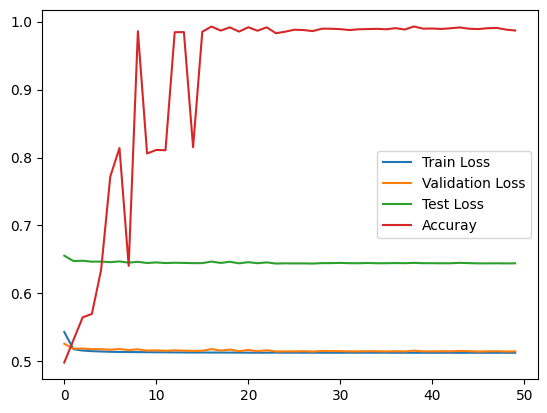

In [ ]:
# please create a folder called 'data' in colab and put 'overfit.tsv' 'train.tsv' 'test.tsv' 'validation.tsv' into 'data' folder
embedding, totalLoss, totalValidationLoss, totalTestLoss, totalAccuray = main(50,4,0.0001,2,4,20,20)
plt.plot(totalLoss, label='Train Loss')
plt.plot(totalValidationLoss, label='Validation Loss')
plt.plot(totalTestLoss, label='Test Loss')
plt.plot(totalAccuray, label='Accuray')
plt.legend()

In [ ]:
print(totalAccuray[-1])

0.9868596881959911


In [ ]:
print(max(totalAccuray))

0.9927616926503341
